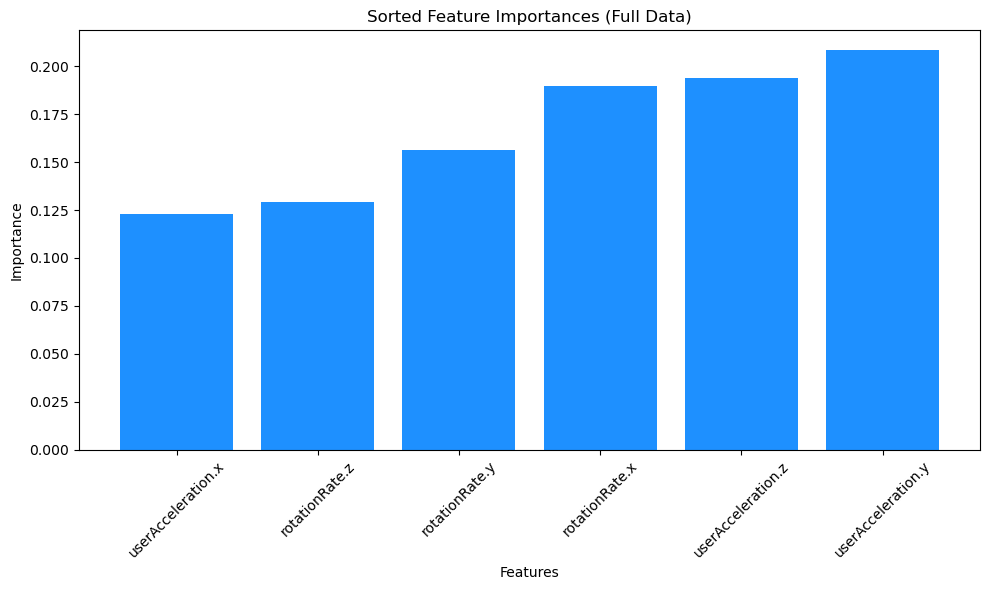

In [2]:
# Use random forest classifier.
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Loading the entire dataset
data_full = pd.read_csv('clean.csv')

# Specifying the features and the target variable
features = [
    "rotationRate.x", "rotationRate.y", "rotationRate.z",
    "userAcceleration.x", "userAcceleration.y", "userAcceleration.z"
]
target = "act"

# Training the Random Forest classifier on the entire data
clf_full_data = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full_data.fit(data_full[features], data_full[target])

# Getting feature importances from the model trained on full data
feature_importances_full = clf_full_data.feature_importances_

# Sorting the features based on importance
sorted_idx = feature_importances_full.argsort()
features_sorted = [features[i] for i in sorted_idx]
importances_sorted = feature_importances_full[sorted_idx]

# Visualizing the sorted feature importances
plt.figure(figsize=(10, 6))
plt.bar(features_sorted, importances_sorted, color='dodgerblue')
plt.title('Sorted Feature Importances (Full Data)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# read the data
df = pd.read_csv('clean.csv')

# delect row of UserAcceleration.x 
df = df.drop('userAcceleration.x', axis=1)

# save the file
df.to_csv('clean_reduced.csv', index=False)


Epoch 1/10
28257/28257 [==============================] - 85s 3ms/step - loss: 0.2685 - accuracy: 0.9136 - val_loss: 0.1774 - val_accuracy: 0.9434
Epoch 2/10
28257/28257 [==============================] - 77s 3ms/step - loss: 0.1720 - accuracy: 0.9446 - val_loss: 0.1462 - val_accuracy: 0.9538
Epoch 3/10
28257/28257 [==============================] - 80s 3ms/step - loss: 0.1464 - accuracy: 0.9521 - val_loss: 0.1313 - val_accuracy: 0.9574
Epoch 4/10
28257/28257 [==============================] - 91s 3ms/step - loss: 0.1304 - accuracy: 0.9567 - val_loss: 0.1229 - val_accuracy: 0.9601
Epoch 5/10
28257/28257 [==============================] - 75s 3ms/step - loss: 0.1198 - accuracy: 0.9596 - val_loss: 0.1130 - val_accuracy: 0.9638
Epoch 6/10
28257/28257 [==============================] - 78s 3ms/step - loss: 0.1116 - accuracy: 0.9623 - val_loss: 0.1119 - val_accuracy: 0.9636
Epoch 7/10
28257/28257 [==============================] - 84s 3ms/step - loss: 0.1053 - accuracy: 0.9642 - val_loss: 0

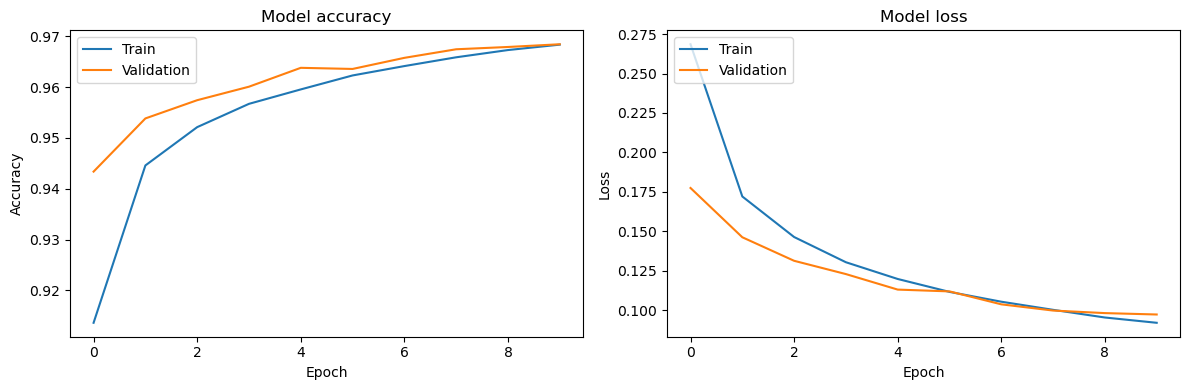

35321/35321 [==============================] - 23s 647us/step


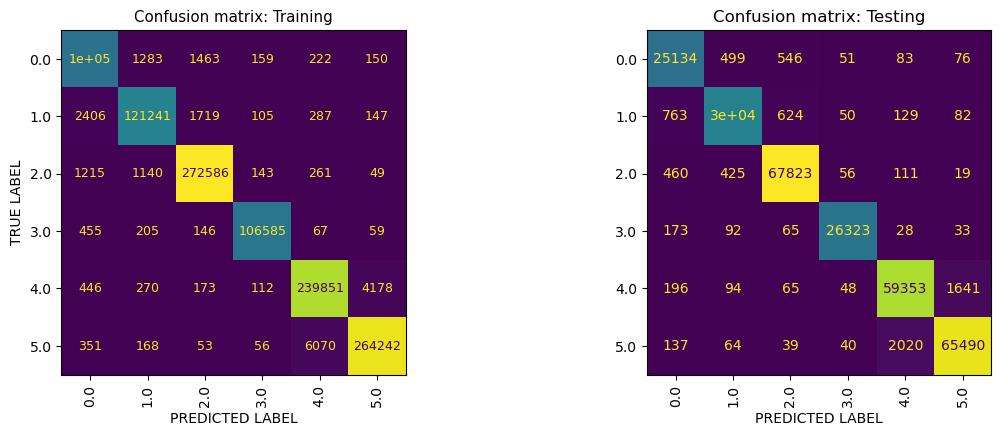

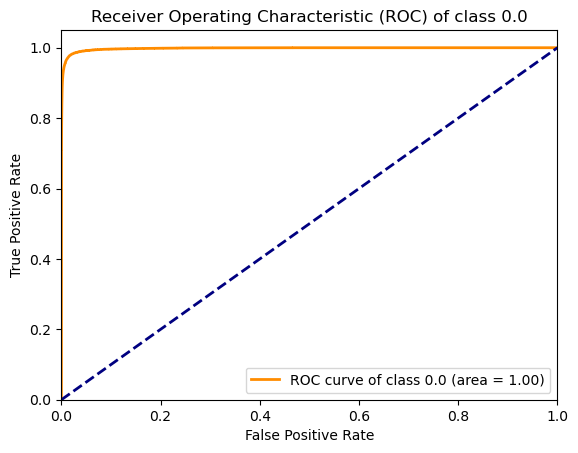

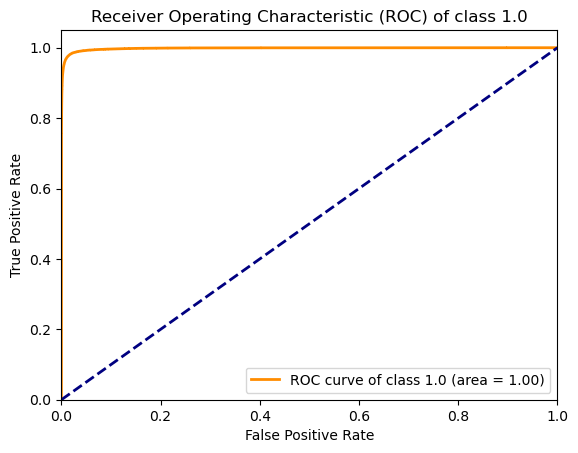

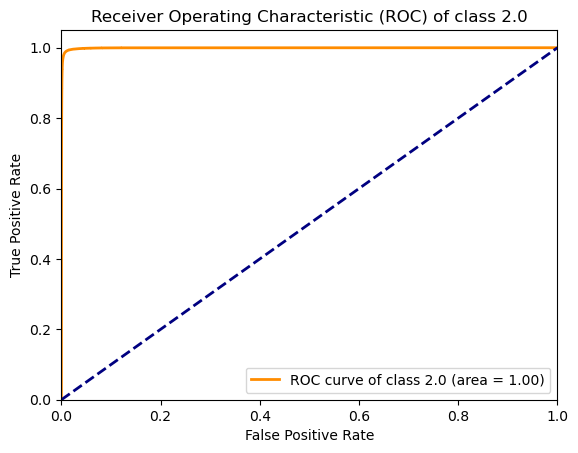

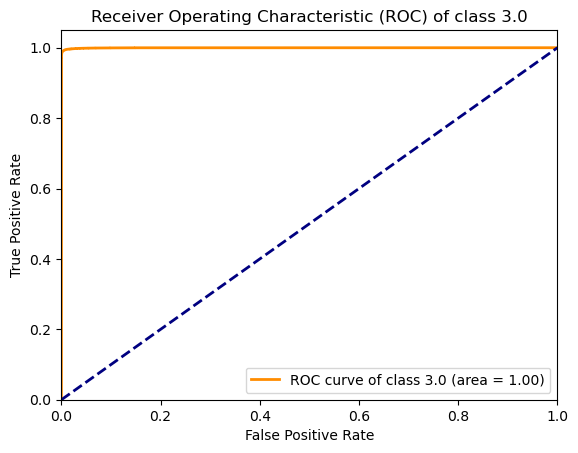

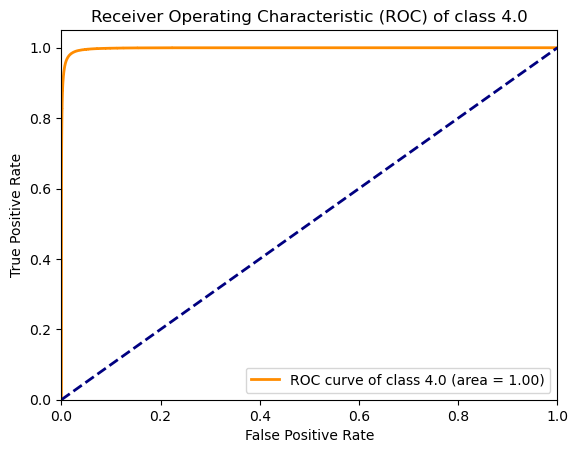

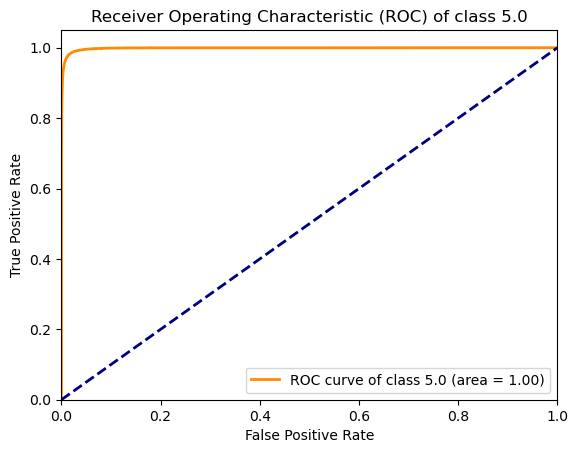

Accuracy: 0.9691786639486983
Confusion Matrix: 
[[25134   499   546    51    83    76]
 [  763 29732   624    50   129    82]
 [  460   425 67823    56   111    19]
 [  173    92    65 26323    28    33]
 [  196    94    65    48 59353  1641]
 [  137    64    39    40  2020 65490]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     26389
           1       0.96      0.95      0.95     31380
           2       0.98      0.98      0.98     68894
           3       0.99      0.99      0.99     26714
           4       0.96      0.97      0.96     61397
           5       0.97      0.97      0.97     67790

    accuracy                           0.97    282564
   macro avg       0.97      0.97      0.97    282564
weighted avg       0.97      0.97      0.97    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/Final_code/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/Final_code/cnn_model/assets


In [5]:
# Delete UserAcceleration.x feature. And still have high accuracy.
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_reduced.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


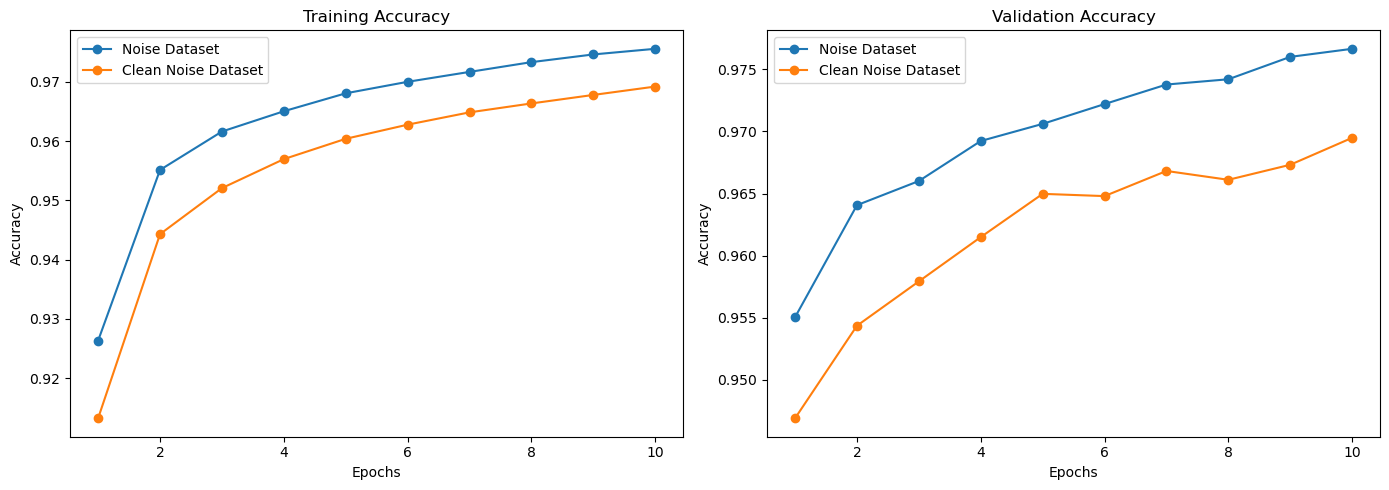

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to create sliding windows
def create_windows(data, window_size, step_size=1):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
        labels.append(label)
    return np.array(windows), np.array(labels)

# Function to train the model and get accuracies
def train_model_get_accuracy(file_path, epochs=10):
    dataset = pd.read_csv(file_path)
    data_with_labels = np.c_[dataset.drop(columns=['act']).values, pd.factorize(dataset['act'])[0]]
    X, y = create_windows(data_with_labels, window_size=50, step_size=1)
    y = pd.get_dummies(y).values
    X = np.array([StandardScaler().fit_transform(window) for window in X])
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['accuracy'], history.history['val_accuracy']

# Paths to the datasets
clean_file_path = 'clean.csv'
reduce_file_path = 'clean_reduced.csv'

# Training on both datasets
clean_train_acc, clean_val_acc = train_model_get_accuracy(clean_file_path)
reduce_train_acc, reduce_val_acc = train_model_get_accuracy(reduce_file_path)

epochs_range = range(1, 11)

# Plotting
plt.figure(figsize=(14, 5))

# Training accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs_range, clean_train_acc, marker='o', label='Noise Dataset')
plt.plot(epochs_range, reduce_train_acc, marker='o', label='Clean Noise Dataset')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, clean_val_acc, marker='o', label='Noise Dataset')
plt.plot(epochs_range, reduce_val_acc, marker='o', label='Clean Noise Dataset')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
